# Face Recognition: Look How Far We've Come (Part 3)

In this notebook, I continuue from Solution 1's canonical Eigenface approach and Solution 2's Haar Cascade approach and start expoloring Deep Learning ("DL"). N.B.:  While the below does reflect a good DL solution, resulting from different models, parameters, and the like, it by no means reflects an excellent one.   Rather, the results of this Part 3, as well as of the predecessor parts, are used to inform betterments to the DL approach to this classification problem derived from the upshot of this Part 3 and of its precedecessor parts. 

# 3. The Deep Learning Approach

In [1]:
# Import the libraries needed for the deep learning approach to facial recognition
from keras.engine import Model
from keras.layers import Input
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Dropout, Activation, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils 
from keras.callbacks import ModelCheckpoint
# Now we need TensorFlow itself, as well same control (see Section 3.2 below) of its memory allocation
import tensorflow as tf
from keras.backend import clear_session
from keras.backend.tensorflow_backend import set_session
# Now we need the VGG16 model optimized for face recognition, VGGFace
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
# Re-import libraries from prior sections in the event that you are restarting here
import numpy as np
import math
import cv2
import os
import string
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from copy import copy, deepcopy
import pickle as pkl
%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
# Restore from file anything saved from previous sections
with open('pic_dir.pickle', 'rb') as picture_path:
    image_3D_dir = pkl.load(picture_path)
    home_dir = pkl.load(picture_path)
    lfw_img_dir = pkl.load(picture_path)
    project_folder = pkl.load(picture_path)
    project_path = pkl.load(picture_path)
with open('images_3D_RGB_top7.pickle', 'rb') as picture_pickle:
    images_3D_RGB = pkl.load(picture_pickle)
with open('df_ground_truth.pickle', 'rb') as ground_truth_pickle:
    df_ground_truth = pkl.load(ground_truth_pickle)
with open('testing_data.pickle', 'rb') as testing_data_pickle:
    train_X = pkl.load(testing_data_pickle)
    test_X = pkl.load(testing_data_pickle)
    train_y = pkl.load(testing_data_pickle)
    test_y = pkl.load(testing_data_pickle)
    test_y_int = pkl.load(testing_data_pickle)
    test_y_names = pkl.load(testing_data_pickle)
    n_classes = pkl.load(testing_data_pickle)
    name_image_counts = pkl.load(testing_data_pickle)
    person_names = pkl.load(testing_data_pickle)
    index_name_dict = pkl.load(testing_data_pickle)
    name_index_dict = pkl.load(testing_data_pickle)                        

# 3.1 Preprocess the data and One Hot Encode ("OHE") the labels

In [3]:
# Now One Hote Encode ("OHE") the string labels to Bernoulli vectors
from keras.utils import np_utils

# Now let's split the test data between validation and testing
half_test_len = math.floor((len(test_y))/2)
val_X, val_y = test_X[0:half_test_len], test_y[0:half_test_len]
test_X, test_y = test_X[half_test_len:], test_y[half_test_len:]

# train_y to train_y_vectors
train_y_int = [int(y_tr) for y_tr in train_y]
train_y_names = [person_names[i] for i in train_y]
train_y_vectors = np_utils.to_categorical(train_y_int, num_classes=n_classes).astype(int)

# val_y (as taken from 1st half of test_y above) to val_y_vectors
val_y_int = [int(y_va) for y_va in val_y]
val_y_names = [person_names[i] for i in val_y]
val_y_vectors = np_utils.to_categorical(val_y_int, num_classes=n_classes).astype(int)

# test_y (as halved) to test_y_vectors
test_y_int = [int(y_te) for y_te in test_y]
test_y_names = [person_names[i] for i in test_y]
test_y_vectors = np_utils.to_categorical(test_y_int, num_classes=n_classes).astype(int)

<Figure size 432x288 with 0 Axes>

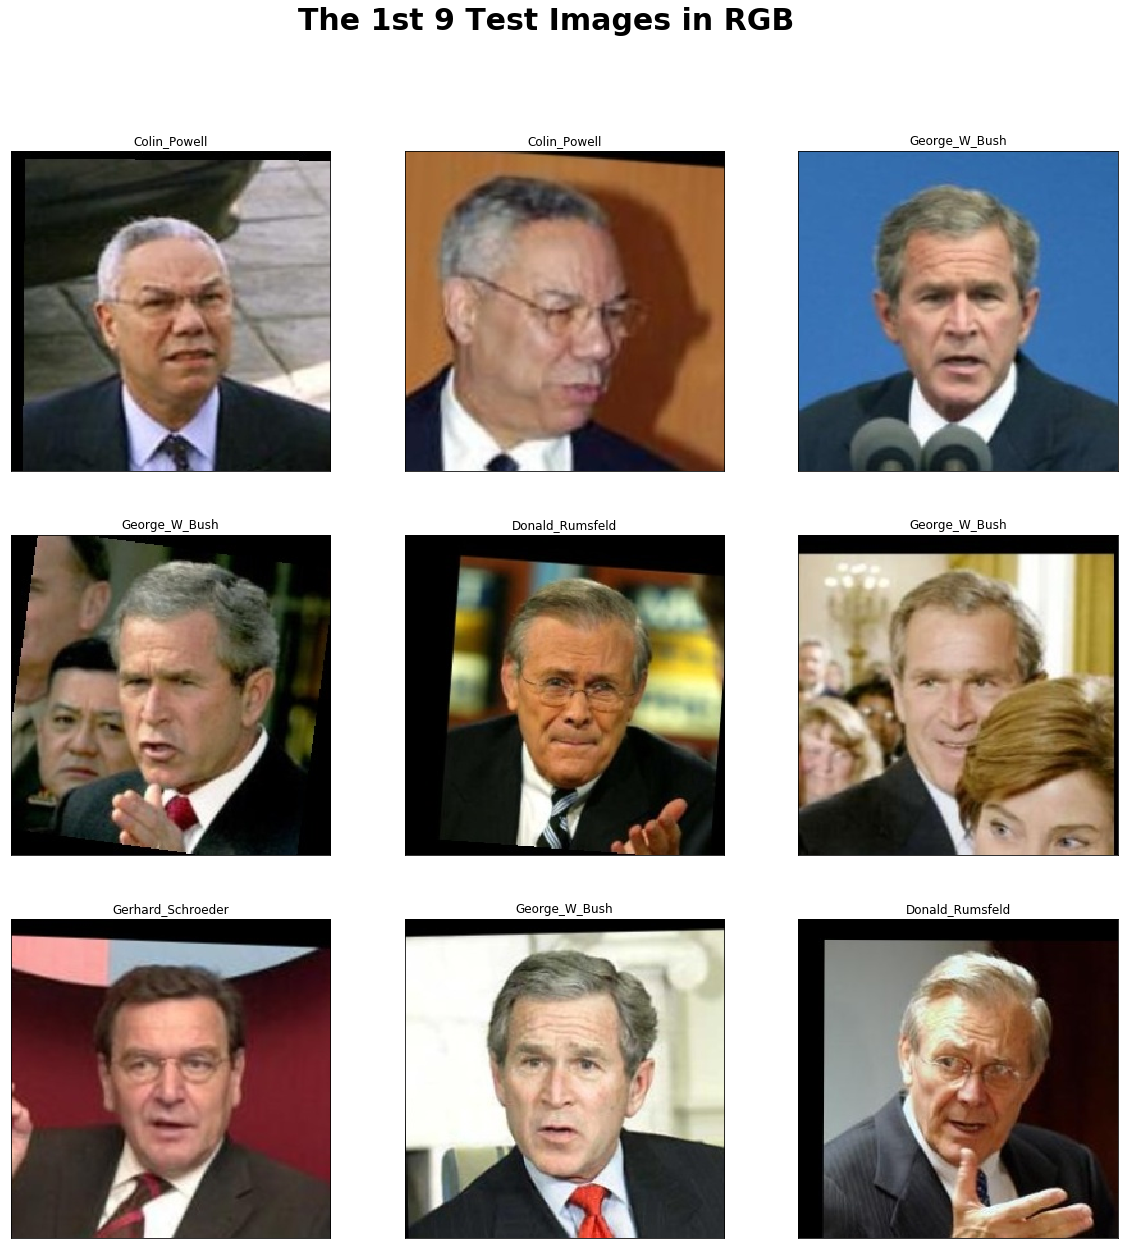

In [4]:
# Let's pick the 1st 9 testing images to view
plt.clf()
sample_cnt = 9
img_indices = np.arange(0,sample_cnt)
test_images_sample = [test_X[img_idx] for img_idx in img_indices]
test_name_titles = test_y_names[0:sample_cnt]
# For each of the above pictures find the face bounding box
plt.figure(figsize=(20,20))
plt.suptitle('The 1st 9 Test Images in RGB', fontsize=30, weight='bold')

for i in range(sample_cnt):
    plt.subplot(331 + (i))
    plt.title(test_name_titles[i])
    plt.xticks([])
    plt.yticks([])   
    plt.imshow(test_images_sample[i])

plt.show()

In [5]:
# Define a function to process the images to computable tensors
BGR_means = np.array([93.5940, 104.7624, 129.1863]) # used to process input (in BGR order) in keras_vggface.utils.py 
img_height_req, img_width_req, img_channels_req = 224, 224, 3 # 2D image requirements for VGG (& VGGFace)
def image_to_tensor(img):
    img = cv2.resize(img,(img_height_req, img_width_req)).astype('float32')
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = img_to_array(img) # Above converts RGB image back to GBR, the expected color channel chronology of vgg_face
    img = np.absolute(img - BGR_means) # a negative pixel value = its opposite but might confuse models
    img = np.expand_dims(img, axis=0) 
    return np.squeeze(img) # get rid of extraneous axis 0; it will be added with a rank-4 tensor enclosing these

# Reshape and pre-process each train_X, val_X, and test_X.  Then aggregate them into 3 lists

# Copies 1st so as not to change original images
train_X_copy = [deepcopy(img) for img in train_X]
val_X_copy = [deepcopy(img) for img in val_X]
test_X_copy = [deepcopy(img) for img in test_X]
# Normalize as is required for VGGFace
train_X_tf = [image_to_tensor(img) for img in train_X_copy]
val_X_tf = [image_to_tensor(img) for img in val_X_copy]
test_X_tf = [image_to_tensor(img) for img in test_X_copy]

# Reshape the image sets into the required rank_4 tensor shapes (Number_samples, 224,224,3)
train_X_tensors = np.array(train_X_tf)
val_X_tensors = np.array(val_X_tf)
test_X_tensors = np.array(test_X_tf)

# Reshape the label vectors into the required rank_2 tensor shapes (Number_samples, 7)
train_y_tensors = train_y_vectors
val_y_tensors = val_y_vectors
test_y_tensors = test_y_vectors

# Now print summaries of the 3 groups of data and their labels to see if correct
# Adapted from https://github.com/udacity/deep-learning/blob/master/transfer-learning/Transfer_Learning_Solution.ipynb
print("Training shapes (x, y):", train_X_tensors.shape, train_y_tensors.shape)
print("Validation shapes (x, y):", val_X_tensors.shape, val_y_tensors.shape)
print("Testing shapes (x, y):", test_X_tensors.shape, test_y_tensors.shape)

Training shapes (x, y): (1030, 224, 224, 3) (1030, 7)
Validation shapes (x, y): (129, 224, 224, 3) (129, 7)
Testing shapes (x, y): (129, 224, 224, 3) (129, 7)


# 3.2 Build a base CNN model atop VGGFace (transfer learning), predict, and evaluate

The default memory allocation sub-algorithm of TensorFlow is to allocate nearly all of available GPU space to the TF graph. This can easily cause Out-Of-Memory ("OOM") and related problems, crashing the program. The below script allows for dynamic, rather than initially greedy, processing memory allocation.

In [6]:
# Cause TF to allocate GPU memory dynamically, hopefully obviating out-of_memory ("OOM") & other problems
# From https://github.com/keras-team/keras/issues/4161

clear_session()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [7]:
# Design the initial feature extractor model, i.e., obtain the "bottleneck", or 'bn' features
vgg_features = VGGFace(include_top=False, input_shape=(img_height_req, img_width_req, img_channels_req), pooling='avg')
last_layer = vgg_features.get_layer('pool5').output
vgg_f_bn = Model(vgg_features.input, last_layer)
vgg_f_bn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [8]:
# Now obtain the training set logits directly from the bn model
codes_train_bn = vgg_f_bn.predict(train_X_tensors, batch_size=16)
np.save('features_train_bn.npy', codes_train_bn)

In [9]:
# Now obtain the validation set logits directly from the bn model
codes_val_bn = vgg_f_bn.predict(val_X_tensors, batch_size=16)
np.save('features_val_bn.npy', codes_val_bn)

In [10]:
# Top model paramaters
learning_rate = 0.001
epochs = 50
beta_one = 0.9
beta_two = 0.999
epsilon = 1e-4
decay_rate = 0.025
amsgrad_bool = False
batch_size = 16

In [11]:
# Instantiate the top model
top_vgg_f_model = Sequential()
top_vgg_f_model.add(Flatten(input_shape=codes_train_bn.shape[1:]))
top_vgg_f_model.add(Dense(512, activation='relu'))
top_vgg_f_model.add(Dropout(0.5))
top_vgg_f_model.add(Dense(256, activation='relu'))
top_vgg_f_model.add(Dropout(0.5))
top_vgg_f_model.add(Dense(n_classes, activation='relu'))
top_vgg_f_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 1799      
Total params: 12,978,695
Trainable params: 12,978,695
Non-trainable params: 0
________________________________________________________________

In [12]:
# Train the top model

top_model_weights_best = 'top_model_weights_best.h5'
datagen_top = ImageDataGenerator(rescale=1.0)
generator_top = datagen_top.flow(val_X_tensors, val_y_tensors, batch_size=batch_size)
train_data = np.load('features_train_bn.npy')
validation_data = np.load('features_val_bn.npy')

# Now ready the top_vgg_f_model for training
adam = Adam(lr=learning_rate, beta_1=beta_one, beta_2=beta_two, epsilon=epsilon, decay=decay_rate, amsgrad=amsgrad_bool)
top_vgg_f_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
top_vgg_f_model.summary()

checkpointer = ModelCheckpoint(filepath=top_model_weights_best, verbose=1, save_best_only=True)
history = top_vgg_f_model.fit(train_data, train_y_tensors, epochs=epochs, batch_size=batch_size,
                        validation_data=(validation_data, val_y_tensors),callbacks=[checkpointer], verbose=1)

top_vgg_f_model.save_weights(top_model_weights_best)

(eval_loss, eval_accuracy) = top_vgg_f_model.evaluate(validation_data, val_y_tensors, batch_size=batch_size, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 1799      
Total params: 12,978,695
Trainable params: 12,978,695
Non-trainable params: 0
________________________________________________________________

Epoch 33/50
1030/1030 [==============================] - 1s 1ms/step - loss: 0.3639 - acc: 0.9408 - val_loss: 0.2498 - val_acc: 0.9612

Epoch 00033: val_loss improved from 0.25408 to 0.24978, saving model to top_model_weights_best.h5
Epoch 34/50
1030/1030 [==============================] - 1s 1ms/step - loss: 0.4211 - acc: 0.9262 - val_loss: 0.2536 - val_acc: 0.9612

Epoch 00034: val_loss did not improve
Epoch 35/50
1030/1030 [==============================] - 1s 1ms/step - loss: 0.3523 - acc: 0.9243 - val_loss: 0.3638 - val_acc: 0.9612

Epoch 00035: val_loss did not improve
Epoch 36/50
1030/1030 [==============================] - 1s 1ms/step - loss: 0.3841 - acc: 0.9369 - val_loss: 0.2789 - val_acc: 0.9457

Epoch 00036: val_loss did not improve
Epoch 37/50
1030/1030 [==============================] - 1s 1ms/step - loss: 0.3042 - acc: 0.9369 - val_loss: 0.2529 - val_acc: 0.9612

Epoch 00037: val_loss did not improve
Epoch 38/50
1030/1030 [==============================] - 1s 1ms/step -

The ultimate evaluation accuracy was 95.3488%
The ultimate evaluation loss was 0.25210679871167335


<Figure size 432x288 with 0 Axes>

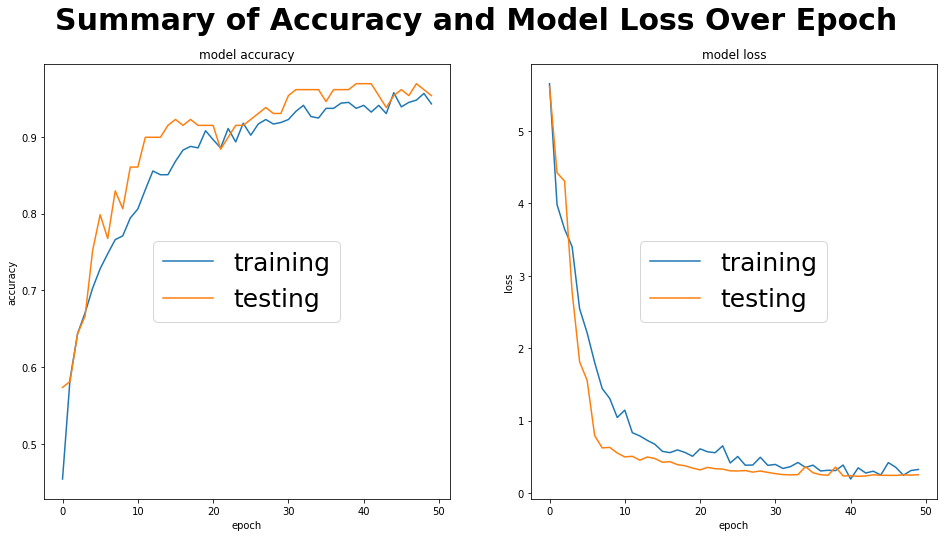

<Figure size 432x288 with 0 Axes>

In [13]:
# Print most common usual results
print('The ultimate evaluation accuracy was {:.4f}%'.format(eval_accuracy * 100))
print('The ultimate evaluation loss was {}'.format(eval_loss))

# Graph the results
plt.clf()
graph_cnt = 2

# Total Graph size and Top Title
plt.figure(figsize=(16,8))
plt.suptitle('Summary of Accuracy and Model Loss Over Epoch', fontsize=30, weight='bold')
# Build Graph Contents
training_metrics = [history.history['acc'], history.history['loss']]
validation_metrics = [history.history['val_acc'], history.history['val_loss']]
horizontal_titles = ['model accuracy', 'model loss']
vertical_axis_labels = ['accuracy', 'loss']
# Build the graph contents
for i in range(graph_cnt):
    plt.subplot(121 + (i))
    plt.plot(training_metrics[i])
    plt.plot(validation_metrics[i])
    plt.title(horizontal_titles[i])
    plt.ylabel(vertical_axis_labels[i])
    plt.xlabel('epoch')
    plt.legend(['training', 'testing'], loc='center', prop={'size': 25})

plt.show()
plt.savefig('top7_raw_training_metrics.png')


In [14]:
# Instantiate the base model
vgg_features_blobs = VGGFace(include_top=False,input_shape=(img_height_req,img_width_req,img_channels_req),pooling='avg')
last_layer = vgg_features_blobs.get_layer('pool5').output
model_canned = Model(vgg_features_blobs.input, last_layer)
print("model_canned is:")
model_canned.summary()

# Instantiate the top model
model_top = Sequential()
model_top.add(Flatten(input_shape=(7,7,512)))
model_top.add(Dense(512, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(n_classes, activation='relu'))
model_top.load_weights(top_model_weights_best)
print("model_top is:")
model_top.summary()

model_canned is:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [15]:
# Define a function to take an image and make a class (person_name/identity) prediction
def predict_person(img):
    image = np.copy(img)
    image = np.array(image)
    image = np.expand_dims(image, axis=0)

    # get the bottleneck prediction from the pre-trained canned_model
    bottleneck_prediction = model_canned.predict(image)
    
    # use the bottleneck prediction on the top model to get the final classification
    pred_probs = model_top.predict(bottleneck_prediction)
    pred_list = np.amax(pred_probs, axis=0).astype(np.uint8).tolist()  
    pred_idx = pred_list.index(max(pred_list))
    pred_class = person_names[pred_idx]
    return pred_class


In [16]:
# Obtain all class/person_name/identity predictions
names_preds = [predict_person(x) for x in test_X_tensors]

In [17]:
# Define a function to convert a y_test_vec (OHE-encoded y_test lable to its class)
def test_y_to_name(y_test_vec):
     y_list = y_test_vec.astype(np.uint8).tolist()
     y_true_idx = y_list.index(max(y_list))
     y_class = person_names[y_true_idx]
     return y_class

In [18]:
names_ground_truth = [test_y_to_name(test_y_tensors[i]) for i in range(len(test_y_tensors))]

In [19]:
# Quantitative evaluation of the model quality on the test set
target_names = [person_names[i] for i in test_y_int]
pred_y_int = [name_index_dict[names_preds[i]] for i in range(len(test_y_int)) ]

test_err_idx = [i for i in range(len(test_y_int)) if test_y_int[i] != pred_y_int[i]]
print('test_err_idx is {}'.format(test_err_idx))
print(classification_report(test_y_int, pred_y_int, target_names=person_names))
print(confusion_matrix(test_y_int, pred_y_int, labels=range(n_classes)))

test_err_idx is [4, 15, 22, 25, 26, 35, 81, 87, 90, 107, 115, 116]
                   precision    recall  f1-score   support

    George_W_Bush       0.89      0.98      0.94        59
      Hugo_Chavez       0.83      0.83      0.83         6
Gerhard_Schroeder       1.00      0.83      0.91        12
     Colin_Powell       0.83      1.00      0.91        20
  Donald_Rumsfeld       1.00      0.69      0.82        13
     Ariel_Sharon       1.00      0.89      0.94         9
       Tony_Blair       1.00      0.70      0.82        10

      avg / total       0.92      0.91      0.90       129

[[58  0  0  1  0  0  0]
 [ 0  5  0  1  0  0  0]
 [ 1  1 10  0  0  0  0]
 [ 0  0  0 20  0  0  0]
 [ 3  0  0  1  9  0  0]
 [ 0  0  0  1  0  8  0]
 [ 3  0  0  0  0  0  7]]


# Pretty good actually.   With such a small dataset, from the perspective of neural networks, this result is okay.   Recall, as well, that the dataset is measurably imbalanced, in particular with a surfeit of George_W_Bush images.  Now, let's see if we can better this a bit.

In [20]:
# First, let's save off the few vgg_face parameters simply entered above
with open('vgg_f_params.pickle', 'wb') as vgg_f_par:
    pkl.dump(BGR_means, vgg_f_par, protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(img_height_req, vgg_f_par, protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(img_width_req, vgg_f_par, protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(img_channels_req, vgg_f_par, protocol=pkl.HIGHEST_PROTOCOL)

# On to Solution 3A (Part 3A), dl_face_sol3A.ipynb, wherein we try to better these somewhat raw results.